In [2]:
import os as os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
from sympy import *
from random import randrange
import keras
from sklearn.metrics import mean_squared_error as mse

In [3]:
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import  Conv2D, MaxPool2D, BatchNormalization, Input, Dense, Dropout, Reshape, Flatten, Add, Lambda, \
    LSTM, GRU, Conv1D, Concatenate, BatchNormalization, TimeDistributed, RepeatVector, Activation
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

In [4]:
#Generate solution for given initial conditions
def solver(nx=40,nt=99,x_len=1,t_len=0.2,plot=True ):
  
    #  Set parameters.
    nx = nx
    nt = nt
    x_length = x_len
    t_length = t_len
    g = 9.8
    
    #  Compute H and UH.
    
    h = np.zeros ( nx )
    uh = np.zeros ( nx )
    hm = np.zeros ( nx - 1 )
    uhm = np.zeros ( nx - 1 )
    x = np.zeros ( nx )
    t = np.zeros ( nt + 1 )
    h_array = np.zeros ( [ nx, nt + 1 ] )
    uh_array = np.zeros ( [ nx, nt + 1 ] )
    #
    #  Define the locations of the nodes and time steps and the spacing.
    #
    x = np.linspace ( 0, x_length, nx )
    t = np.linspace ( 0, t_length, nt + 1 )

    dx = x_length / float ( nx - 1 )
    dt = t_length / float ( nt )
    #  Apply the initial conditions.
    h = initial_conditions ( nx, x )
    uh=np.zeros(nx)
    
    #  Apply the boundary conditions.
    h[0] = h[nx-2]
    h[nx-1] = h[1]
    uh[0] = uh[nx-2]
    uh[nx-1] = uh[1]
    
   

    h_array[0:nx,0] = h[0:nx]
    uh_array[0:nx,0] = uh[0:nx]
    
    #  Take NT more time steps.
    for it in range ( 1, nt + 1 ):
    
    #  Take a half time step, estimating H and UH at the NX-1 spatial midpoints.
        hm[0:nx-1] = ( h[0:nx-1] + h[1:nx] ) / 2.0 \
          - ( dt / 2.0 ) * ( uh[1:nx] - uh[0:nx-1] ) / dx

        uhm[0:nx-1] = ( uh[0:nx-1] + uh[1:nx] ) / 2.0 \
          - ( dt / 2.0 ) * ( \
            uh[1:nx] ** 2    / h[1:nx]   + 0.5 * g * h[1:nx] ** 2 \
          - uh[0:nx-1] ** 2  / h[0:nx-1] - 0.5 * g * h[0:nx-1] ** 2 ) / dx
        
        #  Take a full time step, evaluating the derivative at the half time step,
        #  to estimate the solution at the NX-2 nodes.
      
        h[1:nx-1] = h[1:nx-1] \
          - dt * ( uhm[1:nx-1] - uhm[0:nx-2] ) / dx

        uh[1:nx-1] = uh[1:nx-1] \
          - dt * ( \
            uhm[1:nx-1] ** 2  / hm[1:nx-1] + 0.5 * g * hm[1:nx-1] ** 2 \
          - uhm[0:nx-2] ** 2  / hm[0:nx-2] - 0.5 * g * hm[0:nx-2] ** 2 ) / dx
        
        #  Update the boundary conditions.
        
        h[0] = h[nx-2]
        h[nx-1] = h[1]
        uh[0] = uh[nx-2]
        uh[nx-1] = uh[1]

        #  Copy data into the big arrays.

        h_array[0:nx,it] = h[0:nx]
        uh_array[0:nx,it] = uh[0:nx]

    x_min = min ( x )
    x_max = max ( x )

    h_min = 0.0
    h_max = np.amax ( h_array )

    uh_max = np.amax ( uh_array )
    uh_min = np.amin ( uh_array )
    
    if plot == True:
      #  Animation of H.
      for it in range ( 0, nt + 1 ):
          if it % 100 == 0:

              plt.axis ( [ x_min, x_max, h_min, h_max ] )
              plt.fill_between ( x, 0, h_array[:,it] )
              title_string = ( 'H(T), Step %3d, Time = %f' % ( it, t[it] ) )
              plt.title ( title_string )
              plt.xlabel ( 'X' )
              plt.ylabel ( 'H(X,T)' )
              plt.show ( block = False )
          
      #  Animation of UH.
      for it in range ( 0, nt + 1 ):
          if it % 100 == 0:

              plt.axis ( [ x_min, x_max, h_min, h_max ] )
              plt.fill_between ( x, 0, uh_array[:,it] )
              title_string = ( 'UH(T), Step %3d, Time = %f' % ( it, t[it] ) )
              plt.title ( title_string )
              plt.xlabel ( 'X' )
              plt.ylabel ( 'UH(X,T)' )
              plt.show ( block = False )
   
      print ( 'Normal end of execution.' )

    return h_array, uh_array, x, t


In [5]:
#Random ICs
def initial_conditions ( nx, x ):

    H0=10
    x_max= np.amax(x)
    bumps=randrange(2,10)
    amp = np.random.rand(bumps)* (0.05*H0)
    pos = np.random.rand(bumps)*(0.75*x_max) + (0.125*x_max)
    Dissapation = 250

    Gaussian = H0*np.ones(nx)
    for i in range(len(amp)):
      if i%2 == 0:
        Gaussian += amp[i]*np.exp(-Dissapation*(x-pos[i])**2)

      elif i%2 != 0:
        Gaussian -= amp[i]*0.5*np.exp(-Dissapation*(x-pos[i])**2)
    
    h =  Gaussian
    return h

#Take only every n step in time and space
def prep_data(h,u,x,t,n):
    
    h= np.transpose(h[::n,::n])
    u= np.transpose(u[::n,::n])
    x=x[::n]
    t=t[::n]
    
    
    training_h= np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))
    labels_h=   np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))

    training_u= np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))
    labels_u=   np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))

    
    for i in range(0,len(h)-1):
        training_h[i] = h[i]
        labels_h[i] = h[i+1]
    
    for i in range(0,len(u)-1):
        training_u[i] = u[i]
        labels_u[i] = u[i+1]

    t=t[:-1]
        
    return training_h, labels_h, training_u, labels_u, x, t

#Merge several data sets with different ICs into one set of data for generality
def generate_data (rounds,nx,x_length,t_length):

  nt=nx-1


  h_array, uh_array, x, t   = solver (nx=nx, nt=nt, x_len= x_length, t_len= t_length,plot=False)
  training_h, labels_h, training_u, labels_u, x, t = prep_data(h_array, uh_array, x, t,n=4)

  for i in range(rounds -1):

    h_array, uh_array, x, t=solver (nx=nx, nt=nt, x_len= x_length, t_len= t_length,plot=False)

    training_hTemp, labels_hTemp, training_uTemp, labels_uTemp, x, t= prep_data(h_array, uh_array, x, t,n=4)

    training_h =np.concatenate((training_h,training_hTemp),axis=0)
    labels_h= np.concatenate((labels_h,labels_hTemp),axis=0)
    training_u=np.concatenate((training_u,training_uTemp),axis=0)
    labels_u=np.concatenate((labels_u,labels_uTemp),axis=0)
 
 

  return training_h,labels_h, training_u, labels_u ,x,t

def normalize(data):
  min = np.amin(data)
  max = np.amax(data)
  data = (data-min)/(max-min)
  return data 

def standardize(data):
  μ = np.mean(data)
  std = np.std(data)
  data = (data-μ)/std
  return data

def generate_zeros(nodes):
  l=[[0]]
  l=l*nodes
  l=np.array(l)
  l=np.transpose(l)
  return l

  
def prep_multi_step(array,p):
  new= []
  for i in range(0,len(array),p):
    step = array[i:p+i]
    new.append(step)
    
  return np.array(new)

In [6]:
def main_data(rounds,nx,x_len):

  nx=nx
  nt= 2*nx -1
  x_len= x_len
  t_len= x_len/15

  training_h,labels_h, training_u, labels_u,x,t  = generate_data (rounds,nx,x_len,t_len)

  training_h=normalize(training_h)
  labels_h=normalize(labels_h)
  training_u=normalize(training_u)
  labels_u=normalize(labels_u)

  return training_h,labels_h, training_u, labels_u,x,t


In [7]:
training_h,labels_h, training_u, labels_u,x,t= main_data(64,1024,1.5);

In [8]:
step=6
training_h = prep_multi_step(training_h,step)
labels_h   = prep_multi_step(labels_h,step)
training_u = prep_multi_step(training_u,step)
labels_u   = prep_multi_step(labels_u,step)

In [9]:
testing_h,testing_hy, testing_u, testing_uy,x,t =main_data(8,1024,1.5)
testing_h = prep_multi_step(testing_h,step)
testing_hy   = prep_multi_step(testing_hy,step)
testing_u = prep_multi_step(testing_u,step)
testing_uy   = prep_multi_step(testing_uy,step)

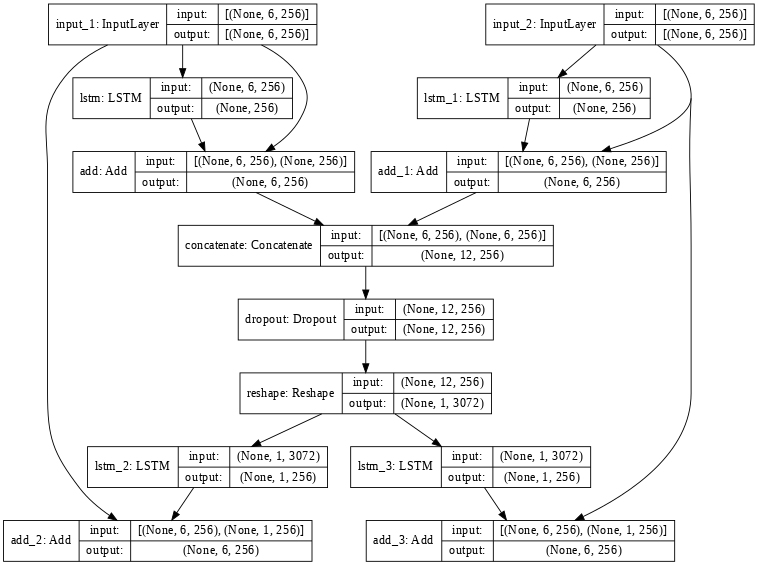

In [10]:
#my code
nodes= len(x)

input_layer_h = Input(shape=(step,nodes))
input_layer_u = Input(shape=(step,nodes))


b_h = LSTM(int(nodes),activation='tanh')(input_layer_h)
b_u = LSTM(int(nodes),activation='tanh')(input_layer_u)

b_h= Add()([input_layer_h,b_h])
b_u= Add()([input_layer_u,b_u])

b = Concatenate(axis=1)([b_h,b_u])
b = Dropout(0.25)(b)
b = Reshape([1, -1])(b)


h = LSTM(nodes,activation='tanh', return_sequences=True)(b)
u = LSTM(nodes,activation='tanh', return_sequences=True)(b)

out_h=Add()([input_layer_h,h])
out_u=Add()([input_layer_u,u])

model = Model([input_layer_h, input_layer_u], [out_h, out_u])
model.compile(optimizer='adam',loss='mse')
#odel.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
opt= tf.keras.optimizers.Adam(learning_rate=0.001) 
model.compile(optimizer=opt, loss='mse')

#model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [11]:
callback = EarlyStopping(monitor='mean_squared_error', patience=5)
hist=model.fit((training_h,training_u),(labels_h,labels_u),batch_size=8,epochs=6,validation_split=0.25,verbose=1)

Epoch 1/6
255/255 [==============================] - 36s 118ms/step - loss: 9.7648e-04 - add_2_loss: 4.8911e-04 - add_3_loss: 4.8738e-04 - val_loss: 3.6250e-05 - val_add_2_loss: 1.7446e-05 - val_add_3_loss: 1.8804e-05
Epoch 2/6
255/255 [==============================] - 28s 110ms/step - loss: 3.7326e-05 - add_2_loss: 1.7982e-05 - add_3_loss: 1.9343e-05 - val_loss: 3.6249e-05 - val_add_2_loss: 1.7445e-05 - val_add_3_loss: 1.8804e-05
Epoch 3/6
255/255 [==============================] - 28s 110ms/step - loss: 3.8350e-05 - add_2_loss: 1.8420e-05 - add_3_loss: 1.9930e-05 - val_loss: 3.6247e-05 - val_add_2_loss: 1.7443e-05 - val_add_3_loss: 1.8804e-05
Epoch 4/6
255/255 [==============================] - 28s 109ms/step - loss: 3.8207e-05 - add_2_loss: 1.8284e-05 - add_3_loss: 1.9923e-05 - val_loss: 3.6246e-05 - val_add_2_loss: 1.7442e-05 - val_add_3_loss: 1.8804e-05
Epoch 5/6
255/255 [==============================] - 28s 109ms/step - loss: 3.6817e-05 - add_2_loss: 1.7665e-05 - add_3_loss: 1.

In [12]:
font = {'size'   : 16}
plt.rc('font', **font)

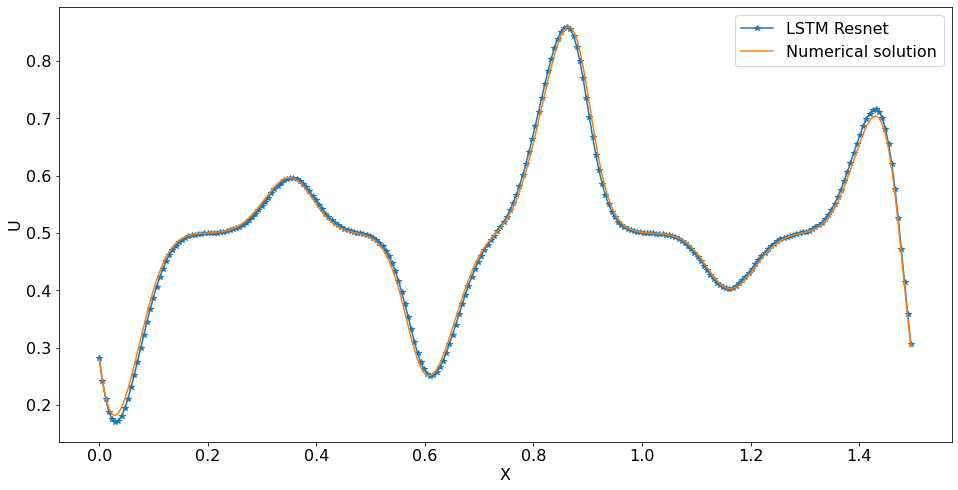

In [13]:
pred= np.array(model.predict((testing_h,testing_u)))
fig, axes = plt.subplots(figsize=(16,8))
plt.plot(x,pred[1][60][0],'*-',label='LSTM Resnet')
plt.plot(x,testing_uy[60][0],label='Numerical solution')
plt.xlabel("X")
plt.ylabel("U")
#plt.title("Height")
plt.legend()
plt.savefig('LSTM Res U.png')

plt.show()

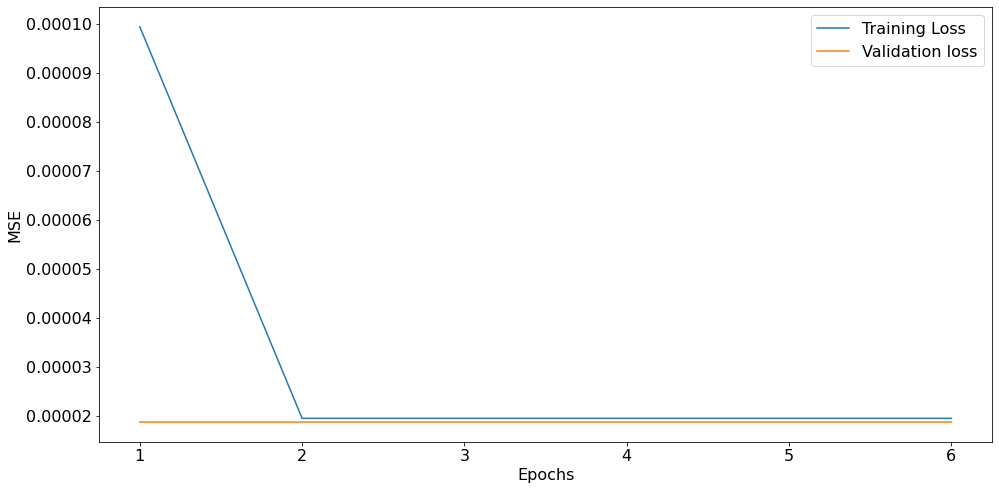

In [16]:
loss=hist.history['add_3_loss']
val_loss=hist.history['val_add_3_loss']
epochs=np.linspace(1,6,6)
fig, axes = plt.subplots(figsize=(16,8))
plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation loss')
#plt.title("Loss function per eoc")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.savefig('U loss Dense Res.pdf')  
plt.show()

Where I get the error.

In [30]:
def error(pred,test):
  error=[]
  for i in range(len(pred)):
    error.append(mse(pred[i][0],test[i][0]))
  error=np.array(error)
  avg= np.mean(error)
  return avg

In [31]:
pred_h=pred[0]
pred_u=pred[1]
mse_h= error(pred_h,testing_hy)
mse_u= error(pred_u,testing_uy)

print('Error for H and U respectively are',mse_h, 'and',mse_u)


Error for H and U respectively are 3.965104768341828e-05 and 4.6486391174924485e-05
